In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
def build_raised_cosine_matrix(nh, endpoints, b, dt):
    
    """
    Make basis of raised cosines with logarithmically stretched time asis.
    
    Ported from [matlab code](https://github.com/pillowlab/raisedCosineBasis) 
    by Jonathan Pillow
    
    Parameters
    ==========
    nh : int
        number of basis vectors
    
    endpoints : array like, shape=(2, )
        absoute temporal position of center of 1st and last cosine basis vector
        
    b : float
        offset for nonlinear stretching of x axis: y=log(x+b)
    
    dt : float
        time bin size of bins representing basis
        
    Return
    ======
    
    ttgrid : shape=(nt, )
        time lattice on which basis is defined
    
    basis : shape=(nt, nh)
        original cosine basis vectors
        
    """
    
    def nl(x):
        return np.log(x + 1e-20)
    
    def invnl(x):
        return np.exp(x) - 1e-20
    
    def raised_cosine_basis(x, c, dc):
        return 0.5 * (np.cos(np.maximum(-np.pi,np.minimum(np.pi,(x-c)*np.pi/dc/2)))+1)
    
    yendpoints = nl(endpoints + b)
    dctr = np.diff(yendpoints) / (nh - 1)
    ctrs = np.arange(yendpoints[0], yendpoints[1]+dctr, dctr)
    maxt = invnl(yendpoints[1]+2*dctr) - b
    ttgrid = np.arange(0, maxt, dt)
    nt = len(ttgrid)
    
    xx = np.tile(nl(ttgrid+b)[:, np.newaxis], (1, nh))
    cc = np.tile(ctrs, (nt, 1))
    
    basis = raised_cosine_basis(xx, cc, dctr)
    
    return ttgrid, basis

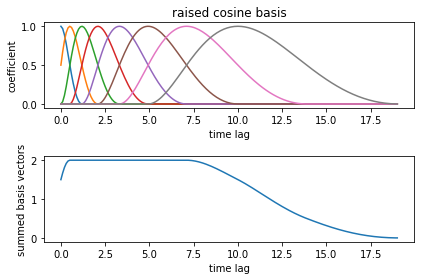

In [3]:
nh = 8 # number of basis vectors
endpoints = np.array([0, 10]) # location of 1st and last cosines
b = 1.5 # nonlinear stretch factor (larger => more linear)
dt = 0.1 # time bin size

tt, B = build_raised_cosine_matrix(nh, endpoints, b, dt)
fig, ax = plt.subplots(2,1)
ax[0].plot(tt, B)
ax[0].set_ylabel('coefficient')
ax[0].set_title('raised cosine basis')

ax[1].plot(tt, B.sum(1))
ax[1].set_ylabel('summed basis vectors')
ax[1].set

for i in range(2): 
    ax[i].set_xlabel('time lag')
    
fig.tight_layout()

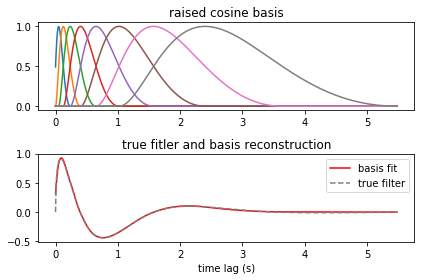

In [4]:
dt = 0.01
tgrid = np.arange(0, 5+dt, dt)
kfilt = np.exp(-1*tgrid) * np.sin(5 * tgrid ** 0.5)

nh = 8 # number of basis vectors
endpoints = np.array([.05, 2.4]) # location of 1st and last cosines
b = .1 # nonlinear stretch factor (larger => more linear)

tt, B = build_raised_cosine_matrix(nh, endpoints, b, dt)
fig, ax = plt.subplots(2,1)
ax[0].plot(tt, B)
ax[0].set_title('raised cosine basis')

kfilt_intrp = interp1d(tgrid, kfilt, fill_value='extrapolate')(tt)
wts = np.linalg.solve(B.T @ B, B.T @ kfilt_intrp)
khat = B @ wts
ax[1].plot(tt, khat, color='red', label='basis fit')
ax[1].plot(tt, kfilt_intrp, color='grey', linestyle='--', label='true filter')
ax[1].set_xlabel('time lag (s)')
ax[1].legend()
ax[1].set_title('true fitler and basis reconstruction')

fig.tight_layout()